# House Price Analysis with Linear Regression - EDA

by Cassie Nutter

---
___
***

The focus of this project will be centered around first time home buyers using data from houses sold in King County in 2014 and 2015.

## Data Cleaning
Data is the process of detecting and correcting (or removing) corrupt or inaccurate records from a record set, table, or database and refers to identifying incomplete, incorrect, inaccurate or irrelevant parts of the data and then replacing, modifying, or deleting the dirty or coarse data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import statsmodels.stats.api as sms

import warnings
warnings.filterwarnings(action= 'ignore', category= UserWarning)

#code to display all the columns without truncation
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('data/kc_house_data.csv')

In [3]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

What are all these columns?
Column Names and descriptions for Kings County Data Set
* **id** - unique identified for a house
* **date** - date house was sold
* **price** - price is prediction target
* **bedrooms** - number of Bedrooms/House
* **bathrooms** - number of bathrooms/bedrooms
* **sqft_living** - square footage of the home
* **sqft_lot** -  square footage of the lot
* **floors** - total floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has a view
* **condition** - How good the condition is ( Overall )
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip code
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors


### Datetime

The "date" column is currently an object. Let's change it to datetime, then extract the month and year so we can use those easily and drop the original date column.

In [5]:
df['date'] = pd.to_datetime(df['date'])

In [6]:
df['month_sold'] = df.date.dt.month
df['year_sold'] = df.date.dt.year
df.drop(['date'], axis= 1, inplace= True)

### Odd values 

Let's look to see if anything is weird or out of place.

In [7]:
df.sqft_basement.value_counts(normalize= True)

0.0       0.593879
?         0.021021
600.0     0.010048
500.0     0.009677
700.0     0.009631
            ...   
1913.0    0.000046
1284.0    0.000046
1525.0    0.000046
602.0     0.000046
1024.0    0.000046
Name: sqft_basement, Length: 304, dtype: float64

0.2% of the data is marked as '?' while 59.3% is marked as '0.0'. 

In [8]:
# change ? in column to 0 - most commonly seen value
df['sqft_basement'] = df['sqft_basement'].replace('?', '0.0')

In [9]:
df.sqft_basement.value_counts()

0.0       13280
600.0       217
500.0       209
700.0       208
800.0       201
          ...  
1913.0        1
1284.0        1
1525.0        1
602.0         1
1024.0        1
Name: sqft_basement, Length: 303, dtype: int64

In [10]:
# change data type of basement to float instead of object
df['sqft_basement'] = df.sqft_basement.astype('float64')

In [11]:
# see how many rows have a value for sqft_basement
len (df.loc[df['sqft_basement'] > 0])

8317

Let's look elsewhere and see if there is anything else odd.

In [12]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month_sold,year_sold
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221.000000,21534.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007596,0.233863,3.409825,7.657915,1788.596842,285.716581,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512,6.573969,2014.322962
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086825,0.765686,0.650546,1.173200,827.759761,439.819830,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950,3.115061,0.467619
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,1.000000,2014.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000,4.000000,2014.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000,6.000000,2014.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,550.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000,9.000000,2015.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000,12.000000,2015.000000


That house with 33 bedrooms is definitely odd. Let's check it out.

In [13]:
df.bedrooms.value_counts()

3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

In [14]:
# Let's look at any house that had 10+ bedrooms and see how the 
# house with 33 bedrooms compares
df[df['bedrooms'] >= 10]

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month_sold,year_sold
8748,1773100755,520000.0,11,3.00,3000,4960,2.0,0.0,0.0,3,7,2400,600.0,1918,1999.0,98106,47.5560,-122.363,1420,4960,8,2014
13301,627300145,1150000.0,10,5.25,4590,10920,1.0,0.0,2.0,3,9,2500,2090.0,2008,0.0,98004,47.5861,-122.113,2730,10400,8,2014
15147,5566100170,650000.0,10,2.00,3610,11914,2.0,0.0,0.0,4,7,3010,600.0,1958,0.0,98006,47.5705,-122.175,2040,11914,10,2014
15856,2402100895,640000.0,33,1.75,1620,6000,1.0,0.0,0.0,5,7,1040,580.0,1947,0.0,98103,47.6878,-122.331,1330,4700,6,2014
19239,8812401450,660000.0,10,3.00,2920,3745,2.0,0.0,0.0,4,7,1860,1060.0,1913,0.0,98105,47.6635,-122.320,1810,3745,12,2014


Some ways it doesn't differ too much from the other houses:
* best condition
* similar grade
* median in terms of lot size
* fairly similar number of bathrooms

But, in some ways, it is concerning:
* lowest amount of square footage
* only 1 story / floor
* only 1.75 bathrooms for 33 rooms?
* But, mainly, 33 rooms?!? 

It's too suspicious. Let's just remove it.

In [15]:
# Drop the 33 bedroom house then verify that it is gone
df.drop(index=15856, inplace= True)
# df[df['bedrooms'] >= 10]

### Null values

In [16]:
# look at values in waterfront
df.waterfront.value_counts(normalize= True)

0.0    0.992404
1.0    0.007596
Name: waterfront, dtype: float64

In [17]:
# look at values in view
df.view.value_counts(normalize= True)

0.0    0.901918
2.0    0.044443
3.0    0.023592
1.0    0.015325
4.0    0.014722
Name: view, dtype: float64

In [18]:
# look at values in yr_renovated column
df.yr_renovated.value_counts(normalize= True)

0.0       0.958094
2014.0    0.004112
2003.0    0.001746
2013.0    0.001746
2007.0    0.001690
            ...   
1946.0    0.000056
1959.0    0.000056
1971.0    0.000056
1951.0    0.000056
1954.0    0.000056
Name: yr_renovated, Length: 70, dtype: float64

99.2% of homes are not considered waterfront properties.

90% of homes do not have a view. While there are more categories, and replacing the null values with 0 may still be iffy, there are not very many missing values.

95.8% of homes have never been renovated. 

We can feel secure in replacing those all the missing values with zeros.

In [19]:
df.fillna(0, inplace= True)

### Duplicates

Most columns will likely have duplicates - especially the categorical columns. But the 'id' should have only one id per entry. Let's check that out.

In [20]:
# check id column for duplicate entries
df.id.duplicated().sum()

177

In [21]:
df_id_dups = df[df.duplicated('id')]

In [22]:
df_id_dups.reset_index(drop= True, inplace= True)

In [23]:
df.loc[df['id'] == 6021501535]

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month_sold,year_sold
93,6021501535,430000.0,3,1.5,1580,5000,1.0,0.0,0.0,3,8,1290,290.0,1939,0.0,98117,47.687,-122.386,1570,4500,7,2014
94,6021501535,700000.0,3,1.5,1580,5000,1.0,0.0,0.0,3,8,1290,290.0,1939,0.0,98117,47.687,-122.386,1570,4500,12,2014


In [24]:
df.loc[df['id'] == 4139480200]

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month_sold,year_sold
313,4139480200,1380000.0,4,3.25,4290,12103,1.0,0.0,3.0,3,11,2690,1600.0,1997,0.0,98006,47.5503,-122.102,3860,11244,6,2014
314,4139480200,1400000.0,4,3.25,4290,12103,1.0,0.0,3.0,3,11,2690,1600.0,1997,0.0,98006,47.5503,-122.102,3860,11244,12,2014


In [25]:
df.loc[df['id'] == 3969300030]

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month_sold,year_sold
345,3969300030,165000.0,4,1.0,1000,7134,1.0,0.0,0.0,3,6,1000,0.0,1943,0.0,98178,47.4897,-122.24,1020,7138,7,2014
346,3969300030,239900.0,4,1.0,1000,7134,1.0,0.0,0.0,3,6,1000,0.0,1943,0.0,98178,47.4897,-122.24,1020,7138,12,2014


It looks like the rows that have identical ID numbers were sold a few months apart. I'm going to drop the older data. (AKA the first entries)

In [26]:
df.drop_duplicates(subset= 'id', keep= 'last', inplace= True)

In [27]:
df.id.duplicated().sum()

0

In [28]:
df.reset_index(inplace= True, drop= True)

Great! We took care of duplicates, null values, odd values, and have correct data types.

We can move on to taking a closer look at the data.

### Baseline Model

Let's take a look at a baseline model now that everything is cleaned up.

In [29]:
outcome = 'price'
x_cols = df.drop(['price'], axis= 1).columns

predictors = '+'.join(x_cols)
f = outcome + '~' + predictors
model = ols(formula = f, data= df).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     2399.
Date:                Fri, 15 Jan 2021   Prob (F-statistic):               0.00
Time:                        19:35:02   Log-Likelihood:            -2.9191e+05
No. Observations:               21419   AIC:                         5.839e+05
Df Residuals:                   21397   BIC:                         5.840e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -6.733e+07   9.97e+06     -6.750      0.000   -8.69e+07   -4.78e+07
id            -1.391e-06   4.84e-07     -2.877      0.004   -2.34e-06   -4.44e-07
bedrooms      -3.957e+04   1988.300    -19.901      0.000   -4.35e+04   -3.57e+04
bathrooms      4.349e+04   3274.741     13.282      0.000    3.71e+04    4.99e+04
sqft_living     106.3648     18.075      5.885      0.000      70.937     141.792
sqft_lot          0.1127      0.048      2.352      0.019       0.019       0.207
floors         7352.3096   3601.706      2.041      0.041     292.695    1.44e+04
waterfront     6.167e+05   1.81e+04     34.060      0.000    5.81e+05    6.52e+05
view           5.272e+04   2125.472     24.803      0.000    4.86e+04    5.69e+04
condition      2.785e+04   2361.135     11.793      0.000    2.32e+04    3.25e+04
grade          9.688e+04   2166.681     44.714      0.000    9.26e+04    1.01e+05
sqft_above       76.4357     18.061      4.232      0.000      41.035     111.837
sqft_basement    46.9246     17.899      2.622      0.009      11.841      82.008
yr_built      -2662.7498     72.065    -36.949      0.000   -2804.002   -2521.497
yr_renovated     24.1930      3.982      6.076      0.000      16.388      31.998
zipcode        -586.4237     33.077    -17.729      0.000    -651.257    -521.590
lat            6.027e+05   1.08e+04     56.036      0.000    5.82e+05    6.24e+05
long          -2.153e+05   1.32e+04    -16.312      0.000   -2.41e+05   -1.89e+05
sqft_living15    21.0893      3.452      6.109      0.000      14.323      27.856
sqft_lot15       -0.4052      0.073     -5.518      0.000      -0.549      -0.261
month_sold     1263.5630    708.373      1.784      0.074    -124.902    2652.028
year_sold      3.695e+04   4723.947      7.821      0.000    2.77e+04    4.62e+04
==============================================================================
Omnibus:                    18192.380   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1842217.293
Skew:                           3.558   Prob(JB):                         0.00
Kurtosis:                      47.873   Cond. No.                     3.93e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.93e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

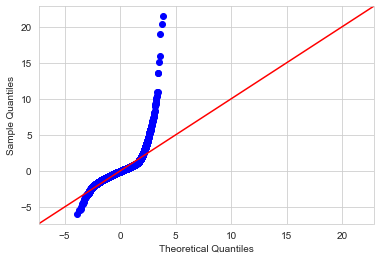

In [30]:
# Q-Q plot
residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

YUCK! That is one ugly Q-Q plot. We can see this data is not normally distributed at all.

We can also see on the summary that the Jarque-Bera test resulted in a very high number. Skew is pretty far off and kurtosis of 47.87? We would like kurtosis to be around 3! This data needs some work.

## Exploratory Data Analysis

Exploratory Data Analysis refers to the critical process of performing initial investigations on data so as to discover patterns,to spot anomalies,to test hypothesis and to check assumptions with the help of summary statistics and graphical representations.

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21419 entries, 0 to 21418
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21419 non-null  int64  
 1   price          21419 non-null  float64
 2   bedrooms       21419 non-null  int64  
 3   bathrooms      21419 non-null  float64
 4   sqft_living    21419 non-null  int64  
 5   sqft_lot       21419 non-null  int64  
 6   floors         21419 non-null  float64
 7   waterfront     21419 non-null  float64
 8   view           21419 non-null  float64
 9   condition      21419 non-null  int64  
 10  grade          21419 non-null  int64  
 11  sqft_above     21419 non-null  int64  
 12  sqft_basement  21419 non-null  float64
 13  yr_built       21419 non-null  int64  
 14  yr_renovated   21419 non-null  float64
 15  zipcode        21419 non-null  int64  
 16  lat            21419 non-null  float64
 17  long           21419 non-null  float64
 18  sqft_l

### Questions?

Given the information we have and that we are looking at data that would be interesting to first time home buyers, let's generate some questions that might conclude some interesting answers.

1. Which season is best to buy a house if you want the lowest price?
2. Does a waterfront or view matter? Could a first time home buyer afford that?
3. Are there some grades or conditions that might be out of reach for a first time home buyer?
4. Is there an area that we can focus on or eliminate?

#### Criteria assumptions
Before we dive into those questions, it would be helpful to get rid of the information that is not pertinent to a first time home buyer. These could be things like:
* houses over a certain price
* houses with a large square footage
* houses with a lot of bedrooms

So, let's work on removing the irrelevant data.

<AxesSubplot:xlabel='price'>

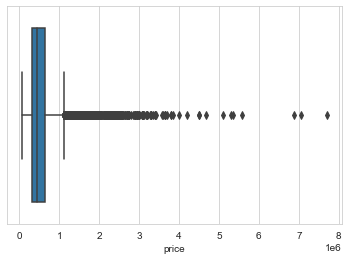

In [32]:
#  Visualize price and outliers
#  Assume for first time home buyer - budget is not more than $850,000
sns.boxplot(x= df['price'])

In [33]:
# remove houses that sold for > $850,000
df = df[df['price'] <= 850000]

<AxesSubplot:xlabel='sqft_living'>

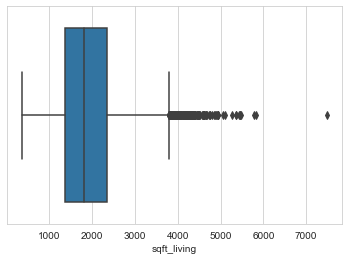

In [34]:
# Visualize houses with high square footage
sns.boxplot(x= df['sqft_living'])

In [35]:
# Whoa! Those are some large houses! Let's cut out the outliers
df = df[df['sqft_living'] <= 4500]

<AxesSubplot:xlabel='bedrooms'>

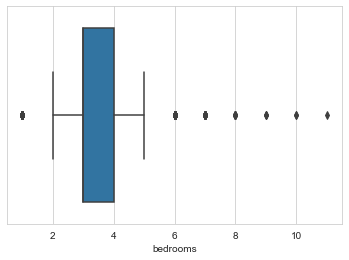

In [36]:
# Visualize bedrooms after houses with large price tags were removed
sns.boxplot(x= df['bedrooms'])

In [37]:
# remove houses with more than 6 bedrooms
df = df[df['bedrooms'] <= 6]

<AxesSubplot:xlabel='sqft_lot'>

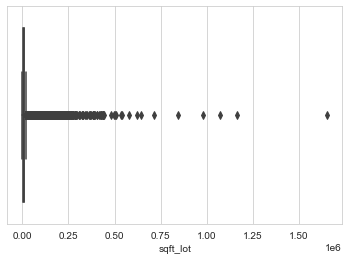

In [38]:
#check lot sizes
sns.boxplot(x= df['sqft_lot'])

In [39]:
df.loc[df['sqft_lot'] > 750000]

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month_sold,year_sold
1702,1020069017,700000.0,4,1.00,1300,1651359,1.0,0.0,3.0,4,6,1300,0.0,1920,0.0,98022,47.2313,-122.023,2560,425581,3,2015
4401,3626079040,790000.0,2,3.00,2560,982278,1.0,0.0,0.0,3,8,2560,0.0,2004,0.0,98014,47.6955,-121.861,1620,40946,7,2014
4500,2522029039,550000.0,3,2.00,3650,843309,2.0,0.0,0.0,4,7,3650,0.0,1991,0.0,98070,47.3627,-122.496,1870,273992,9,2014
7582,2623069031,542500.0,5,3.25,3010,1074218,1.5,0.0,0.0,5,8,2010,1000.0,1931,0.0,98027,47.4564,-122.004,2450,68825,5,2014
17149,3326079016,190000.0,2,1.00,710,1164794,1.0,0.0,0.0,2,5,710,0.0,1915,0.0,98014,47.6888,-121.909,1680,16730,5,2015


Only 5 lots have more than 750,000 square feet (which equals about 17.2 acres). That is still plenty of land for those first time home buyers. Let's remove those 5 houses with very large lots.

<AxesSubplot:xlabel='sqft_lot'>

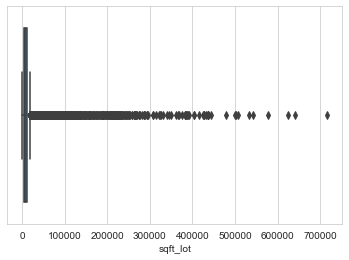

In [40]:
df = df[df['sqft_lot'] < 750000]
sns.boxplot(x= df['sqft_lot'])

#### 1. Which season is best to buy a house if you want the lowest price?

To answer this question, we will have to break the months up into seasons. Then we will find which season has the lowest average sale price.

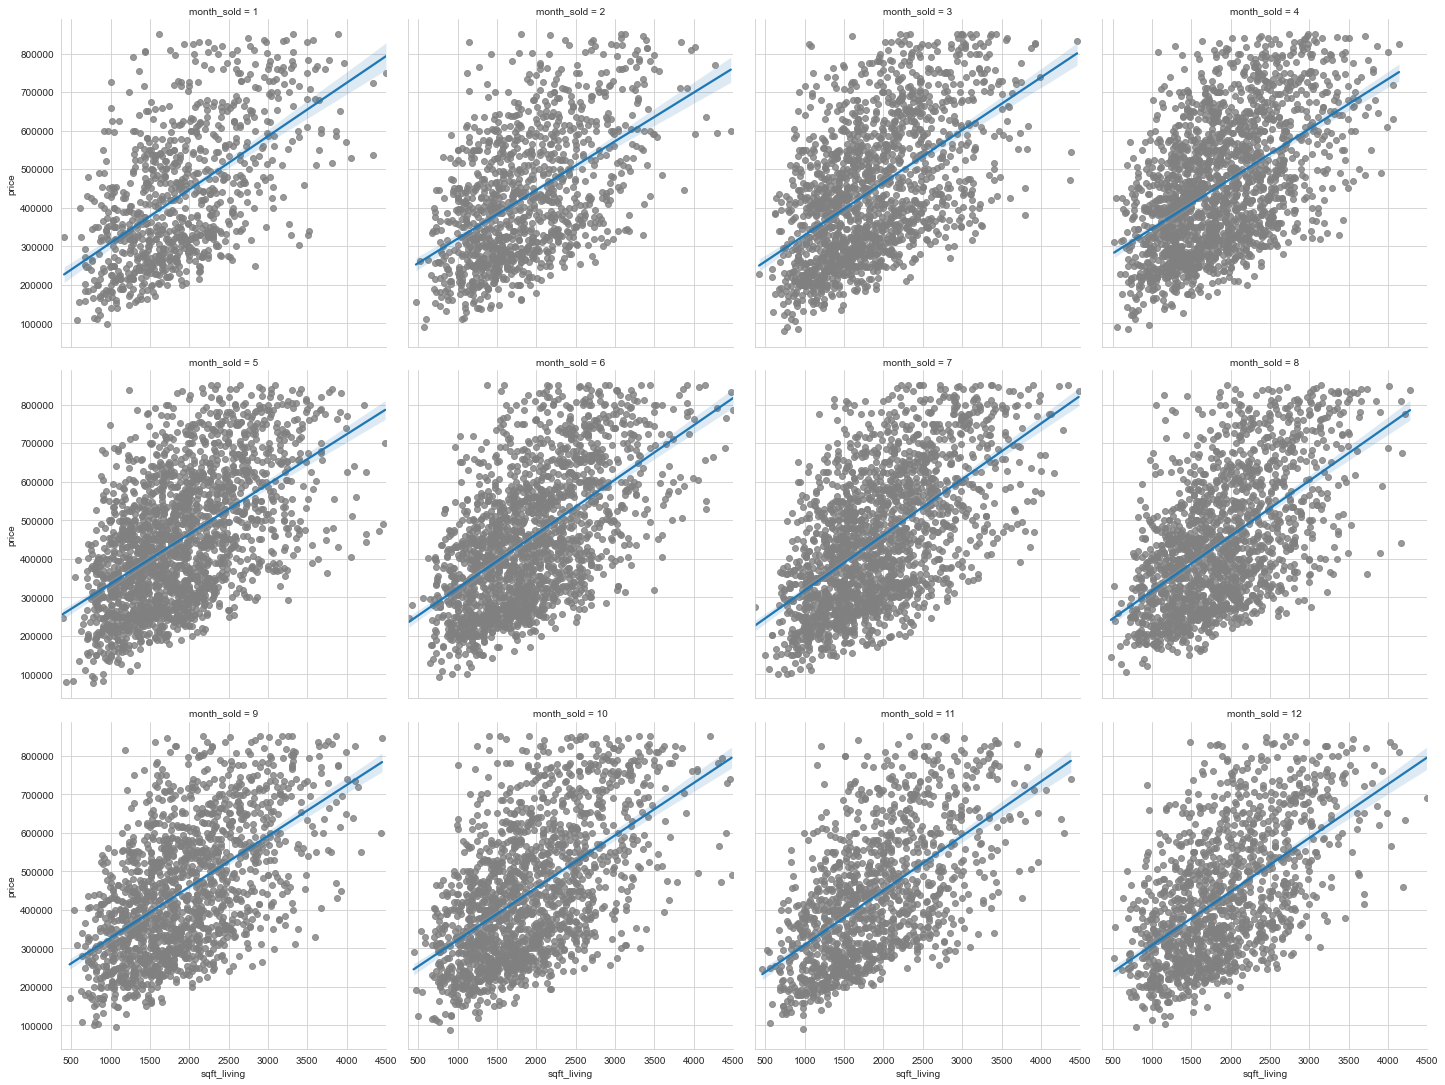

In [41]:
# First, let's look at the months and see if there appears to be a trend
g1 = sns.lmplot(x= 'sqft_living', y= 'price', data= df, col= 'month_sold', 
               col_wrap= 4, scatter_kws = {'color': 'gray'})

A Google search of the seasons in King County (Seattle area) shows most locals think winter is separated into two different kinds - December (winter1) was classified as cold and rainy with a chance of snow while January - March (winter2) is classified as very rainy and windy and cold. 

In [42]:
# set columns for months sold
df.loc[(df['month_sold'] >= 4) & (df['month_sold'] <= 6), 'season'] = 'spring'
df.loc[(df['month_sold'] >= 7) & (df['month_sold'] <= 9), 'season'] = 'summer'
df.loc[(df['month_sold'] == 10) | (df['month_sold'] == 11), 'season'] = 'fall'
df.loc[(df['month_sold'] == 12), 'season'] = 'winter1'
df.loc[(df['month_sold'] <= 3), 'season'] = 'winter2'

Text(0.5, 0, 'Season')

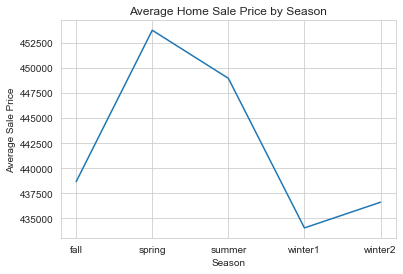

In [43]:
plt.plot(df.groupby('season')['price'].mean().round(2))
plt.title('Average Home Sale Price by Season')
plt.ylabel('Average Sale Price')
plt.xlabel('Season')

Text(0.5, 0, 'Season')

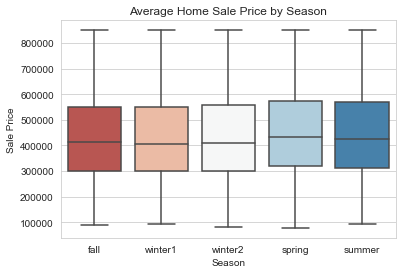

In [44]:
sns.boxplot(x= 'season', y= 'price', data= df, palette= 'RdBu')
plt.title('Average Home Sale Price by Season')
plt.ylabel('Sale Price')
plt.xlabel('Season')

In [45]:
df_s = df.groupby('season')['price'].mean().round(2)
df_s

season
fall       438661.25
spring     453768.93
summer     448972.47
winter1    434043.71
winter2    436607.51
Name: price, dtype: float64

The most expensive season to buy a house is in spring - April through June - with the average sale price with our criteria being \\$453,768.93

The least expensive season to buy a house is in "winter1" or the month of December.
The average home with our search criteria sold for \\$434,043.71

It is important to note here that "winter1" was only one month, where "winter2" is three months. Having more data in "winter2" may have adjusted the results.

When comparing the line graph to the boxplot, you can now see that the amount you would be saving is difficult to see in some seasons. The savings would be about $19,000-20,000 between the least expensive time of year (December) and the most expensive (April - June). 

However, it is interesting to see that fall, winter1, and winter2 don't vary that much from each other. During October through March, one might expect to pay only +/-\\$4,000 for a home.

#### 2. Does a waterfront or view make that much difference in the price?

Let's see how many waterfront properties or houses with views we have. When we took out higher priced homes, it may not have left much data with that criteria.

In [46]:
print(len(df[df['waterfront'] == 1]))
len(df[df['view'] > 0])

39


1245

In [47]:
len(df[df['waterfront'] == 1]) / len(df)

0.0020615287028227084

There were only 39 properties (or .2% of properties) that were sold in the first time home buyer's criteria. If they really want a waterfront property, they may have to wait a while.

In [48]:
len(df[df['view'] > 0]) / len(df)

0.06581033935934032

While 6.5% of the data is still a small portion, a first-time home buyer may have a better chance of getting a home with a view than one on the water.

Text(0.5, 0, 'Sale Price')

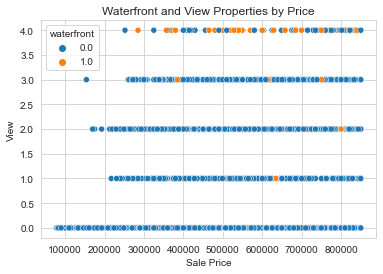

In [49]:
# fig, axes = plt.subplots(nrows= 1, ncols= 2, figsize= (10, 3))

# for xcol, ax in zip([ 'waterfront', 'view'], axes):
#     df.plot(kind= 'scatter', x=xcol, y= 'price', ax=ax, alpha= 0.4)
    
sns.scatterplot(x= 'price', y= 'view', hue= 'waterfront', data= df, 
                palette= 'tab10')
plt.title('Waterfront and View Properties by Price')
plt.ylabel('View')
plt.xlabel('Sale Price')

Now, let's see how much more a home with a view or waterfront would cost.

Text(0.5, 0, 'View Rating')

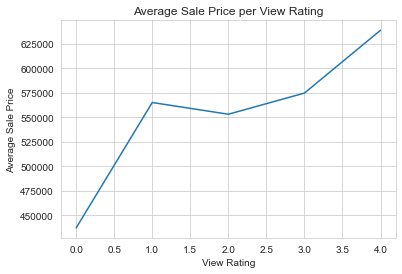

In [50]:
df.groupby('view')['price'].mean().round(2).plot()
plt.title('Average Sale Price per View Rating')
plt.ylabel('Average Sale Price')
plt.xlabel('View Rating')

In [51]:
# Calculate differences between the different views 
# And from having no view to the best view possible
print(df.groupby('view')['price'].mean().round(2).diff())
df.groupby('view')['price'].mean().round(2).diff(periods= 4)

view
0.0          NaN
1.0    127986.33
2.0    -11964.39
3.0     21595.85
4.0     64123.53
Name: price, dtype: float64


view
0.0          NaN
1.0          NaN
2.0          NaN
3.0          NaN
4.0    201741.32
Name: price, dtype: float64

<AxesSubplot:xlabel='waterfront'>

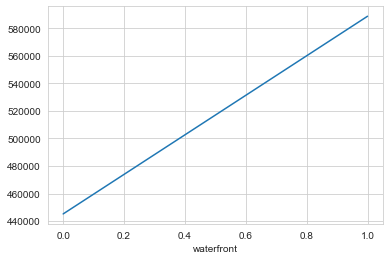

In [52]:
# Visualize average price of waterfront or non-waterfront homes
df.groupby('waterfront')['price'].mean().round(2).plot()

In [53]:
# Difference in average price of homes with and without being on the water
df.groupby('waterfront')['price'].mean().round(2).diff()

waterfront
0.0          NaN
1.0    143636.83
Name: price, dtype: float64

Getting houses with views and waterfronts is possible, but there are not a lot of them out there. Plus, if the first time home buyer does what one of those features, they'll have to pay!<br>

**View:** A view will cost at least \\$116,000 more than if the house had no view. The nicest views cost, on average, an extra \\$201,741.

**Waterfront:** A house or property on the water will run the buyer an extra \\$143,636 more than a house that is inland.

#### 3. Are there some grades or conditions that might be out of reach for a first time home buyer?

<AxesSubplot:xlabel='sqft_living', ylabel='price'>

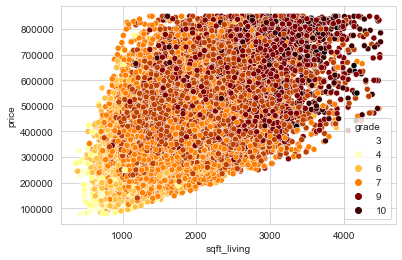

In [54]:
sns.scatterplot(x= 'sqft_living', y= 'price', hue= 'grade', data= df, 
                palette= 'afmhot_r')

Grades do seem to improve with price, but there are some smaller and less expensive homes that have higher grades.

0.0014800718892060472

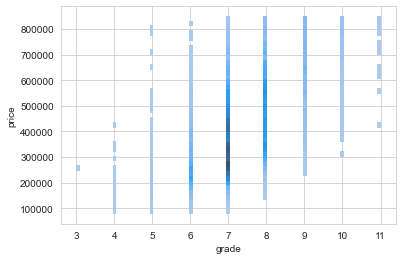

In [55]:
# #Looking at grades of the houses
sns.histplot(x= 'grade', y= 'price', data= df)

# percent of houses sold with a grade "4"
len(df[df['grade'] <= 4]) / len(df)

0.009673326990168095

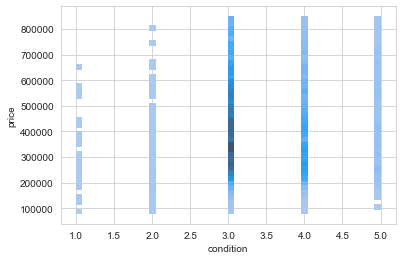

In [56]:
# Looking at conditions of houses
sns.histplot(x= 'condition', y= 'price', data= df)

# percent of houses with a condition of "1 or "2" 
len(df[df['condition'] <= 2]) / len(df)

In [57]:
df.condition.unique()

array([3, 5, 4, 1, 2])

In [58]:
df_pairplot = df[['price', 'sqft_living', 'grade','condition', 'zipcode']]

Text(0.5, 1.0, 'Interactions between Features')

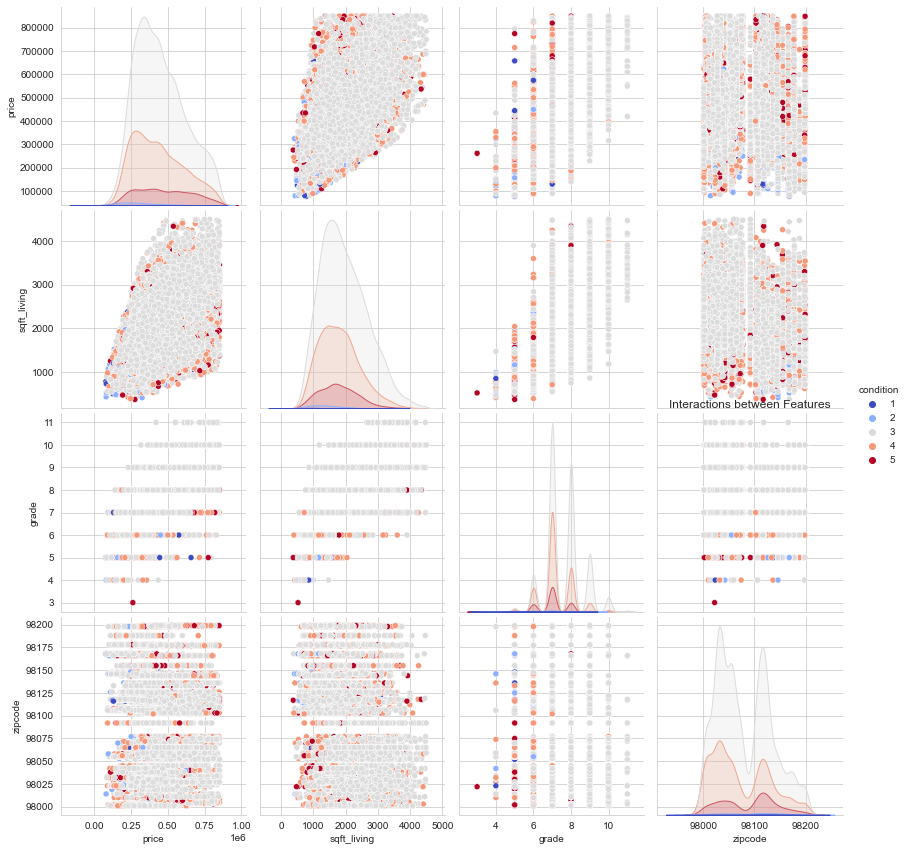

In [59]:
g = sns.pairplot(df_pairplot, hue= 'condition', palette= 'coolwarm', 
                 height= 3)
plt.title('Interactions between Features')

While we may not want a first time home buyer to buy a house in poor condition, there are not many houses that would qualify. Most likely, the house will have a condition of 3 or 4. 

Since condition and grade can be subjective, we can leave them in and let the potential new home owner decide.

#### 4. Is there an area that we can focus on or eliminate?

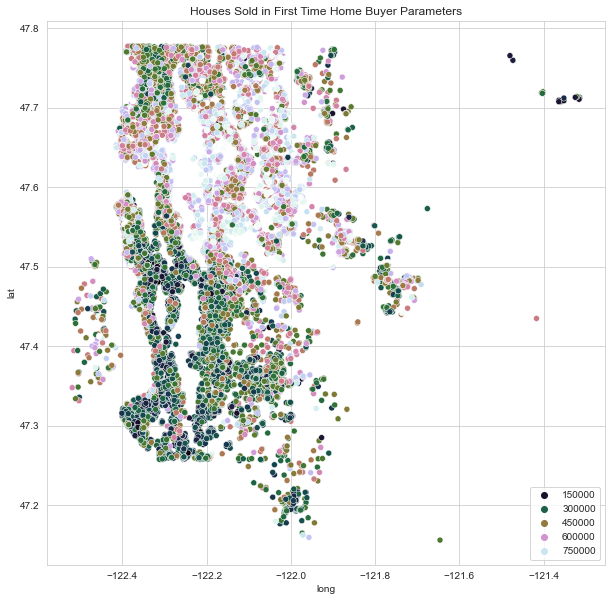

In [60]:
# View house prices on latitude and longitude
plt.figure(figsize=(10,10))
sns.scatterplot(x='long', y='lat', hue='price', data=df, palette= 'cubehelix')
plt.title('Houses Sold in First Time Home Buyer Parameters')
plt.legend(loc= 'lower right');

Appears that the houses that sold for more are on the Northern side. We can separate the areas to see if we are correct.

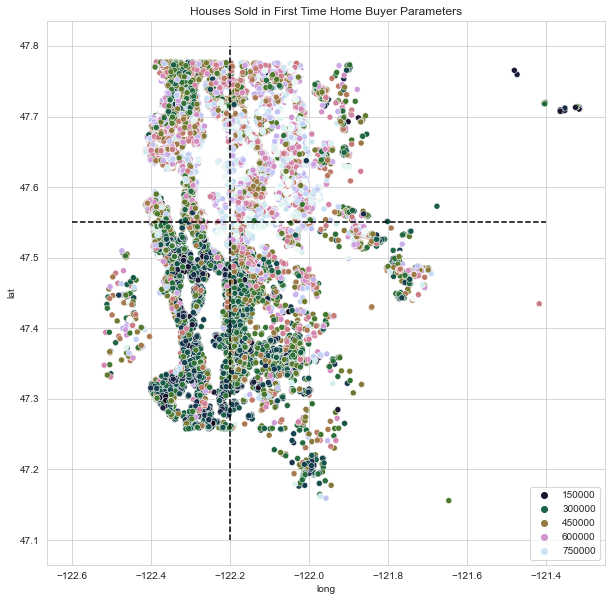

In [61]:
# Add lines where we may want to separate areas based on home sale price
plt.figure(figsize=(10,10))
sns.scatterplot(x='long', y='lat', hue='price', data=df, palette= 'cubehelix')
plt.hlines(y=47.55, xmin=-122.6, xmax=-121.4, colors='black', linestyle='--')
plt.vlines(x=-122.2, ymin=47.1, ymax=47.8, colors='black', linestyle='--')
plt.title('Houses Sold in First Time Home Buyer Parameters')
plt.legend(loc= 'lower right');

That appears to separate the areas fairly evenly. Let's turn the latitude and longitude into quadrants and use the quadrants instead of zipcodes as locators.

In [62]:
# Separate areas into quadrants by latitude and longitude
df.loc[(df['lat'] >= 47.5) & (df['long'] >= -122.2), 'quadrant' ] = 'NW'
df.loc[(df['lat'] > 47.5) & (df['long'] < -122.2), 'quadrant' ] = 'NE'
df.loc[(df['lat'] <= 47.5) & (df['long'] <= -122.2), 'quadrant' ] = 'SW'
df.loc[(df['lat'] < 47.5) & (df['long'] > -122.2), 'quadrant' ] = 'SE'

In [63]:
# did it work?
# df_q3 = df[df['quadrant'] == 3]
# sns.scatterplot(x='long', y='lat', hue='price', data=df_q3, 
#                 palette= 'cubehelix')

The theory is that houses in the Southern quadrants (SW and SE) will be more affordable than those in the NW and NE.

Text(0.5, 0, 'Area in King County')

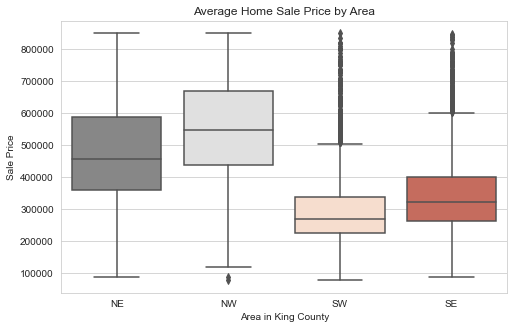

In [64]:
# Create boxplots to show sale prices for each quadrant/sector
plt.figure(figsize= (8,5))
sns.boxplot(x= 'quadrant', y= 'price', data= df, palette= 'RdGy_r')
plt.title('Average Home Sale Price by Area')
plt.ylabel('Sale Price')
plt.xlabel('Area in King County')

Looks like we were right. If we are only looking at homes that are less than $850,000, then houses in the Southern quadrants would, generally, be the least expensive.

In [65]:
df.reset_index(drop= True, inplace= True)

In [66]:
# Save a copy of cleaned and organized data before one-hot encoding or 
# dropping columns

df.to_csv('data/clean_df.csv')

## Feature Engineering

Feature Selection is the process where you automatically or manually select those features which contribute most to your prediction variable or output in which you are interested in. Having irrelevant features in your data can decrease the accuracy of the models and make your model learn based on irrelevant features.

### Multicollinearity

Check for interactions between other features.

In [67]:
corr = df.corr()
corr

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month_sold,year_sold
id,1.000000,0.028556,0.015385,0.035074,0.019794,-0.148617,0.036093,-0.005633,0.018282,-0.032699,0.045563,0.025853,-0.008630,0.031089,-0.009785,-0.006922,0.005102,0.021041,0.020444,-0.145558,-0.008428,0.005821
price,0.028556,1.000000,0.262492,0.401808,0.554367,0.089604,0.249155,0.038107,0.182960,0.027966,0.571697,0.461426,0.201365,0.055784,0.057994,-0.004479,0.462370,0.080328,0.505534,0.075864,-0.007276,-0.004136
bedrooms,0.015385,0.262492,1.000000,0.487680,0.608503,0.022358,0.144462,-0.032872,0.015795,0.021392,0.311732,0.474682,0.272778,0.179939,-0.011229,-0.164765,-0.060695,0.154781,0.382105,0.018123,-0.004521,-0.004336
bathrooms,0.035074,0.401808,0.487680,1.000000,0.695490,0.050708,0.503035,-0.022590,0.056367,-0.144268,0.590636,0.614378,0.192779,0.572251,0.004222,-0.221576,-0.039356,0.254376,0.509669,0.048437,0.012614,-0.029404
sqft_living,0.019794,0.554367,0.608503,0.695490,1.000000,0.157582,0.321014,-0.007131,0.124110,-0.077236,0.660713,0.836951,0.356184,0.365778,0.006213,-0.218801,-0.033603,0.294927,0.720598,0.158839,0.016794,-0.031774
sqft_lot,-0.148617,0.089604,0.022358,0.050708,0.157582,1.000000,-0.031454,0.017831,0.092517,-0.000928,0.085184,0.160934,0.007107,0.041487,0.016591,-0.142598,-0.111588,0.239659,0.159960,0.774416,0.008521,-0.006040
floors,0.036093,0.249155,0.144462,0.503035,0.321014,-0.031454,1.000000,-0.013884,-0.021701,-0.284365,0.450176,0.523115,-0.312952,0.526075,-0.012488,-0.070256,0.021573,0.134686,0.254342,-0.033254,0.015790,-0.024597
waterfront,-0.005633,0.038107,-0.032872,-0.022590,-0.007131,0.017831,-0.013884,1.000000,0.276834,0.011299,-0.018300,-0.018286,0.019170,-0.038384,0.049006,0.037331,-0.040478,-0.054827,0.005215,0.035695,0.006926,-0.006625
view,0.018282,0.182960,0.015795,0.056367,0.124110,0.092517,-0.021701,0.276834,1.000000,0.024616,0.093589,0.038782,0.152512,-0.070895,0.045446,0.102512,-0.041719,-0.074540,0.148780,0.084528,-0.000955,0.004261
condition,-0.032699,0.027966,0.021392,-0.144268,-0.077236,-0.000928,-0.284365,0.011299,0.024616,1.000000,-0.185183,-0.184336,0.170457,-0.350336,-0.049334,-0.005571,-0.020213,-0.093068,-0.132296,0.005041,0.024024,-0.046743


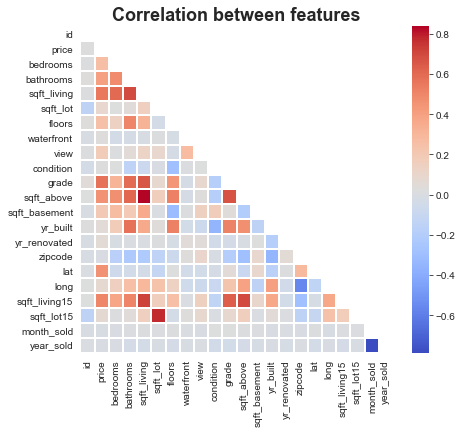

In [68]:
plt.figure(figsize=(7,6))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(df.corr(), cmap= 'coolwarm', mask= mask, linewidth= 1)
plt.title("Correlation between features",weight='bold',fontsize=18)
plt.show()

There are some areas of high correlation. The highest is where "sqft_above" meets "sqft_living". "sqft_living15" also correlates highly across other features. Those will be columns we look forward to removing.

In [69]:
df.drop(columns= ['sqft_above', 'sqft_living15','sqft_lot15', 'month_sold', 
                  'id'], inplace= True)
# df.info()

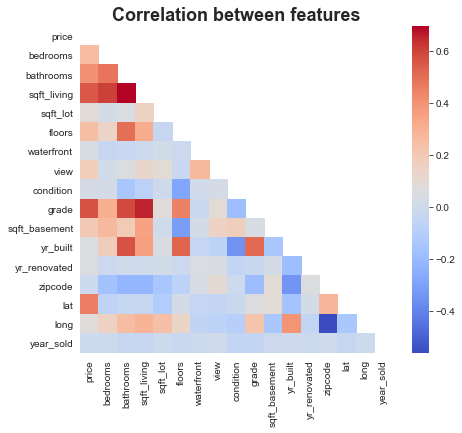

In [70]:
corr1 = df.corr()

plt.figure(figsize=(7,6))
mask = np.triu(np.ones_like(corr1, dtype=bool))
sns.heatmap(df.corr(), cmap= 'coolwarm', mask= mask)
plt.title("Correlation between features",weight='bold',fontsize=18)
plt.show()

### One-hot encoding and binning

Time to work with the data within some of these features to clean it up.
Features we'll focus on are:
* bathrooms
* floors
* grades
* sqft_basement
* view
* yr_renovated

#### Bathrooms and Floors

In [71]:
# make changes to new df
df1 = df.copy()

In [72]:
# look at bathroom data
df1.bathrooms.unique()

array([1.  , 2.25, 3.  , 2.  , 1.5 , 2.5 , 1.75, 2.75, 4.  , 3.25, 3.5 ,
       0.75, 1.25, 3.75, 4.5 , 4.75, 0.5 , 5.  , 4.25, 5.25])

In [73]:
# Only count whole bathrooms
df1['bathrooms'] = df1.bathrooms.astype(int)
df1.bathrooms.unique()

array([1, 2, 3, 4, 0, 5])

In [74]:
# A house shouldn't have 0 bathrooms. Let's change the zeros to ones.
df1['bathrooms'] = df1['bathrooms'].map(lambda x: 1 if x == 0 else x)

In [75]:
# check out the values of floors
df1.floors.unique()

array([1. , 2. , 1.5, 3. , 2.5, 3.5])

In [76]:
# Change floors to whole numbers
# If a house has 1.5 floors, that is more than 1 floor 
df1['floors'] = df1['floors'].map(lambda x: x + 0.5)
df1['floors'] = df1.floors.astype(int)
df1.floors.unique()

array([1, 2, 3, 4])

#### Grade Binning

In [77]:
print ('waterfront: ', df1.waterfront.unique())
print ('condition: ', df.condition.unique())

waterfront:  [0. 1.]
condition:  [3 5 4 1 2]


In [78]:
print ('grade values: ', df1['grade'].unique())

grade values:  [ 7  6  8  9  5 10  4 11  3]


7_8     14347
9_11     2326
5_6      2217
3_4        28
Name: grade, dtype: int64
Sum:  18918


Text(0.5, 0, 'Grades Binned')

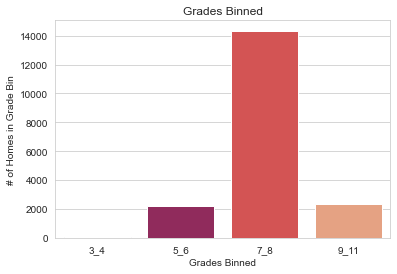

In [79]:
# Let's change waterfront to integers and bin some grades
df1['waterfront'] = df1.waterfront.astype(int)

grade_binned = pd.cut(df['grade'], bins= 4, right= False, 
                      labels = ['3_4', '5_6', '7_8','9_11'])
print(grade_binned.value_counts())
print ('Sum: ', grade_binned.value_counts().sum())
sns.countplot(x= grade_binned, palette= 'rocket')
plt.title('Grades Binned')
plt.ylabel('# of Homes in Grade Bin')
plt.xlabel('Grades Binned')

In [80]:
df2 = df1.copy()

In [81]:
df2.drop(columns= ['grade'], axis= 1, inplace= True)

In [82]:
df2 = pd.concat([df2, grade_binned], names= ['grade_bin'], axis= 1)

In [83]:
df2.rename(columns={'grade': 'grade_binned'}, inplace= True)

In [84]:
grade_dummies = pd.get_dummies(df2['grade_binned'], prefix= 'grade', 
                               drop_first= True)

In [85]:
df2.drop(['grade_binned'], axis= 1, inplace= True)

In [86]:
df2 = pd.concat([df2, grade_dummies], axis= 1)
# df2.head()

<AxesSubplot:>

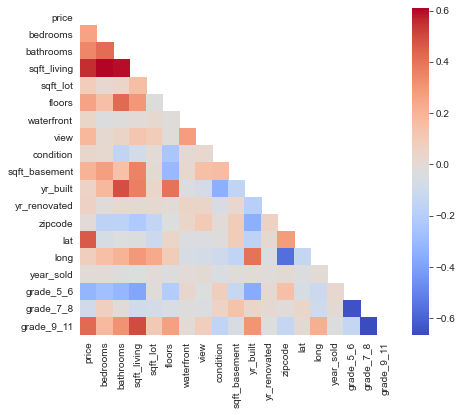

In [87]:
corr2 = df2.corr()

plt.figure(figsize=(7,6))
mask = np.triu(np.ones_like(corr2, dtype=bool))
sns.heatmap(df2.corr(), cmap= 'coolwarm', mask= mask)

#### Basement, views, and renovations

Let's turn sqft_basement, yr_renovated, and view into either has or doesn't have.

In [88]:
df3 = df2.copy()

In [89]:
print ('Num of basement values: ', df.sqft_basement.nunique())
df3['has_basement'] = df3['sqft_basement'].map(lambda x: 1 if x > 0 else 0)

Num of basement values:  238


In [90]:
print ('View values: ', df.view.unique())
df3['has_view'] = df3['view'].map(lambda x: 1 if x > 0 else 0)

View values:  [0. 3. 2. 4. 1.]


In [91]:
print ('Num of renovation values: ', df3.yr_renovated.nunique())
df3['had_renovation'] = df['yr_renovated'].map(lambda x: 1 if x > 0 else 0)

Num of renovation values:  69


In [92]:
df3.drop(columns= ['yr_renovated', 'view', 'sqft_basement'], axis= 1, inplace= True)

In [93]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18918 entries, 0 to 18917
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   price           18918 non-null  float64
 1   bedrooms        18918 non-null  int64  
 2   bathrooms       18918 non-null  int64  
 3   sqft_living     18918 non-null  int64  
 4   sqft_lot        18918 non-null  int64  
 5   floors          18918 non-null  int64  
 6   waterfront      18918 non-null  int64  
 7   condition       18918 non-null  int64  
 8   yr_built        18918 non-null  int64  
 9   zipcode         18918 non-null  int64  
 10  lat             18918 non-null  float64
 11  long            18918 non-null  float64
 12  year_sold       18918 non-null  int64  
 13  season          18918 non-null  object 
 14  quadrant        18918 non-null  object 
 15  grade_5_6       18918 non-null  uint8  
 16  grade_7_8       18918 non-null  uint8  
 17  grade_9_11      18918 non-null 

### Look at Continuous and Categorical Data

In [94]:
# Continuous data
con = ['price', 'sqft_living', 'sqft_lot', 'yr_built', 
       'zipcode','lat','long']

In [95]:
# Categorical data
cat = ['waterfront','condition','grade','year_sold', 
       'season','quadrant', 'bedrooms','bathrooms','floors', 'yr_renovated']

array([[<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'sqft_living'}>,
        <AxesSubplot:title={'center':'sqft_lot'}>],
       [<AxesSubplot:title={'center':'yr_built'}>,
        <AxesSubplot:title={'center':'zipcode'}>,
        <AxesSubplot:title={'center':'lat'}>],
       [<AxesSubplot:title={'center':'long'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

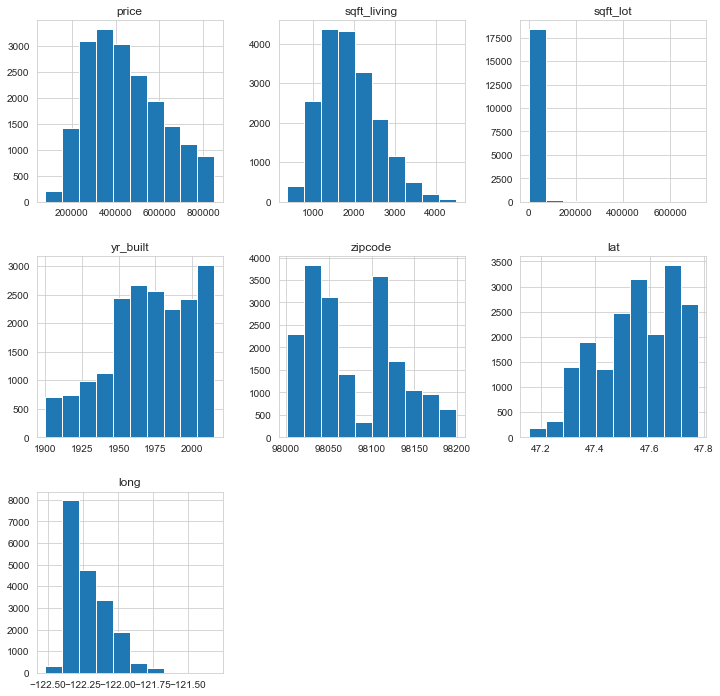

In [96]:
# Look at continuous variables
df_continuous = df.loc[:, con]
df_continuous.hist(figsize= (12, 12))

With the exception of "sqft_lot", these indeed look like they are continuous.

array([[<AxesSubplot:title={'center':'waterfront'}>,
        <AxesSubplot:title={'center':'condition'}>,
        <AxesSubplot:title={'center':'grade'}>],
       [<AxesSubplot:title={'center':'year_sold'}>,
        <AxesSubplot:title={'center':'bedrooms'}>,
        <AxesSubplot:title={'center':'bathrooms'}>],
       [<AxesSubplot:title={'center':'floors'}>,
        <AxesSubplot:title={'center':'yr_renovated'}>, <AxesSubplot:>]],
      dtype=object)

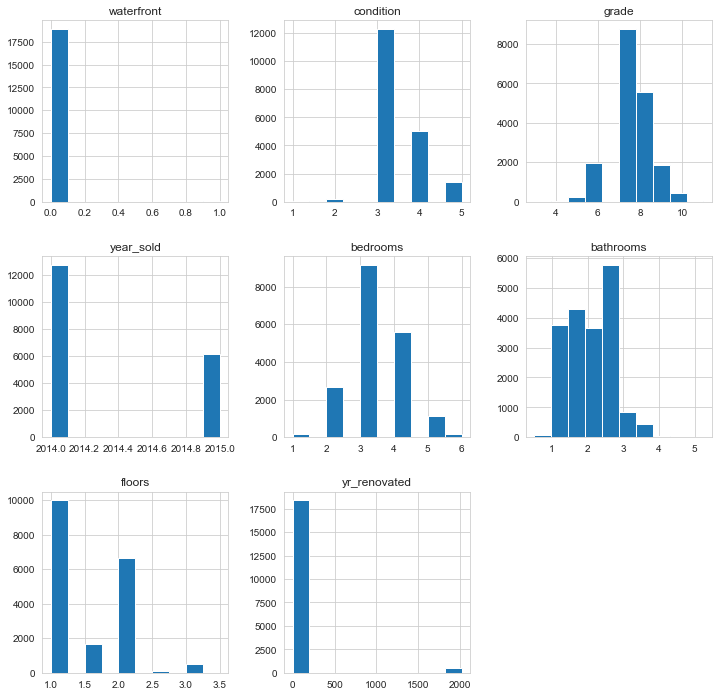

In [97]:
df_categorical = df.loc[:, cat]
df_categorical.hist(figsize= (12, 12))

#### Use Dummy Variables

In [98]:
df4 = df3.copy()

In [99]:
#OHE bedrooms, bathrooms, and floors
bed_dum = pd.get_dummies(df4['bedrooms'], prefix= 'bed', drop_first= True)
bath_dum = pd.get_dummies(df4['bathrooms'], prefix= 'bath', drop_first= True)

In [100]:
# Change type to 'category' rather than OHE
df4['condition'] = df4.condition.astype('category')
df4['floors'] = df4.floors.astype('category')

In [101]:
# Fix seasons and quadrants
season_dum = pd.get_dummies(df4['season'], prefix= 'season', drop_first= True)
quad_dum = pd.get_dummies(df4['quadrant'], prefix= 'quad', drop_first= True)

In [102]:
df4 = pd.concat([df4, bed_dum, bath_dum, season_dum, quad_dum], axis= 1)

In [103]:
df4 = df4.drop(columns= ['bedrooms', 'bathrooms', 'season', 'quadrant'], 
               axis= 1)

In [104]:
df4 = df4.drop(columns = ['lat', 'long', 'zipcode'], axis= 1)

In [105]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18918 entries, 0 to 18917
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   price           18918 non-null  float64 
 1   sqft_living     18918 non-null  int64   
 2   sqft_lot        18918 non-null  int64   
 3   floors          18918 non-null  category
 4   waterfront      18918 non-null  int64   
 5   condition       18918 non-null  category
 6   yr_built        18918 non-null  int64   
 7   year_sold       18918 non-null  int64   
 8   grade_5_6       18918 non-null  uint8   
 9   grade_7_8       18918 non-null  uint8   
 10  grade_9_11      18918 non-null  uint8   
 11  has_basement    18918 non-null  int64   
 12  has_view        18918 non-null  int64   
 13  had_renovation  18918 non-null  int64   
 14  bed_2           18918 non-null  uint8   
 15  bed_3           18918 non-null  uint8   
 16  bed_4           18918 non-null  uint8   
 17  bed_5       

Now that we are done transforming some features, let's save this so we can use it later if needed.

In [106]:
# Save all changes to a csv file
df4.to_csv('data/df_features_clean')

## Modeling and Prediction

Please see other notebook for Model and Prediction using Linear Regression